In [2]:
from PIL import Image
import cv2 as cv
import numpy as np
from ultralytics import SAM
import matplotlib.pyplot as plt
import math
from torch.cuda import is_available
from pathlib import Path
from scipy import ndimage
from tqdm import tqdm
from joblib import delayed, Parallel

In [3]:
def draw(images : list):
    images_per_row = 2

    num_rows = len(images) // images_per_row + int(len(images) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(images):
            ax = axes.flat[i]
            img = images[i]

            ax.imshow(img)
            ax.axis('off')
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
floodnet_dataset_img = [str(path.absolute()) for path in Path('./floodnet/test/img').iterdir()]
floodnet_dataset_label = [str(path.absolute()) for path in Path('./floodnet/test/label').iterdir()]
custom_dataset = [str(path.absolute()) for path in Path('./custom_dataset').iterdir()]

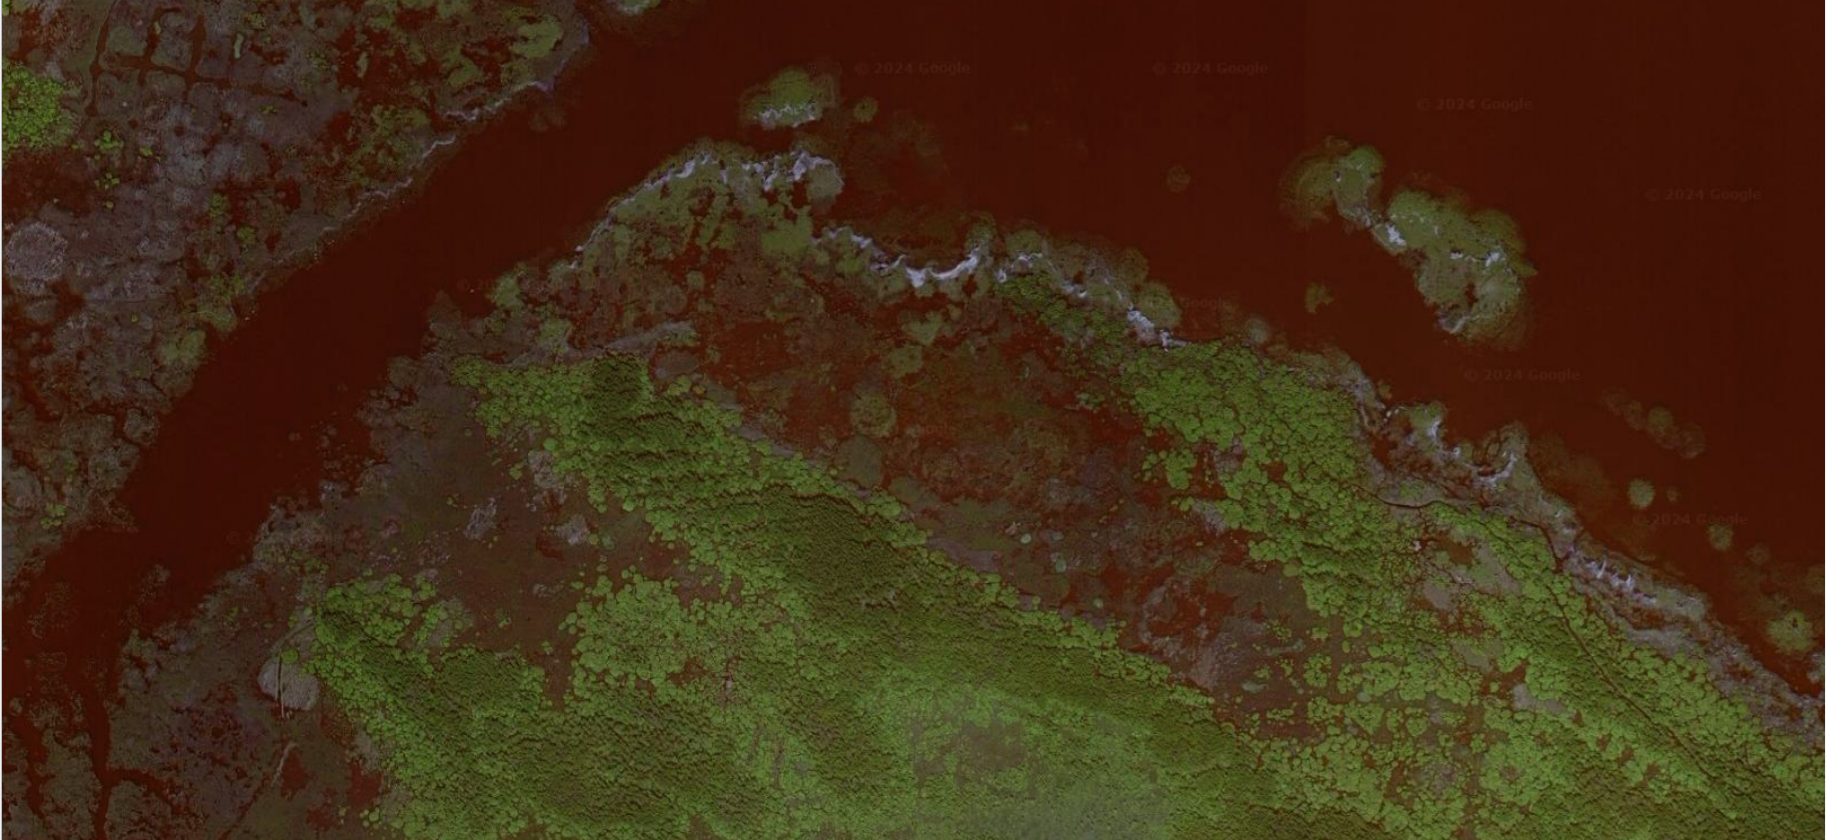

In [5]:
img = cv.imread(custom_dataset[0])
Image.fromarray(img)

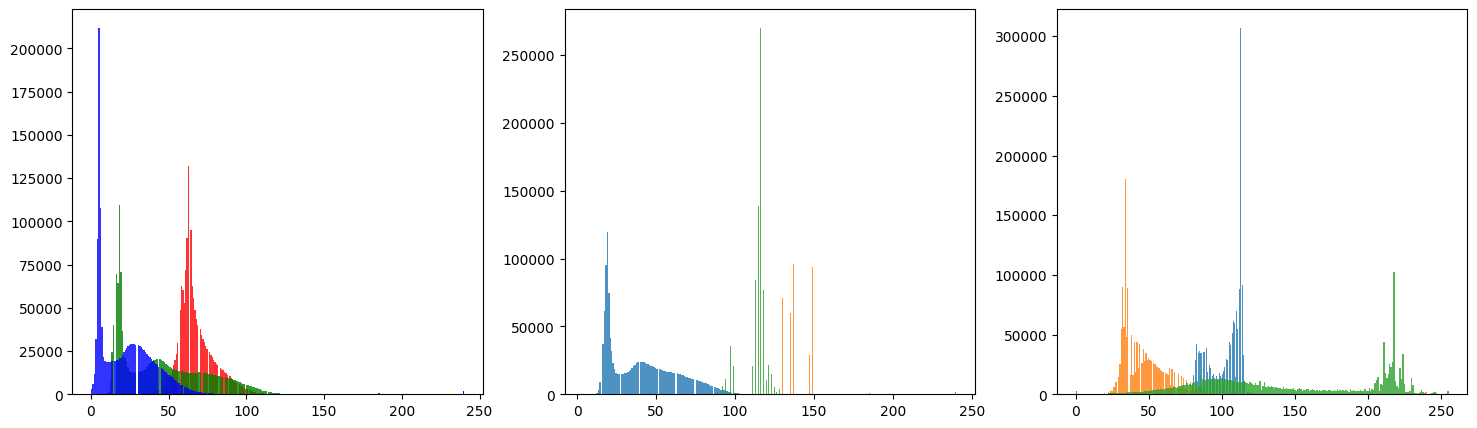

In [6]:
r, g, b = map(np.array, Image.fromarray(img).split())

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,5))

ax1.hist(r.ravel(), bins=256, alpha=0.8, color='red')
ax1.hist(g.ravel(), bins=256, alpha=0.8, color='green')
ax1.hist(b.ravel(), bins=256, alpha=0.8, color='blue')

y,u,v = map(np.array, Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2YUV)).split())

ax2.hist(y.ravel(), bins=256, alpha=0.8)
ax2.hist(u.ravel(), bins=256, alpha=0.8)
ax2.hist(v.ravel(), bins=256, alpha=0.8)

h, l, s = map(np.array, Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2HLS)).split())
ax3.hist(h.ravel(), bins=256, alpha=0.8)
ax3.hist(l.ravel(), bins=256, alpha=0.8)
ax3.hist(s.ravel(), bins=256, alpha=0.8)

plt.show()

In [7]:
def coords_processing(mask, coords):
    coastline_coords = []
    row, col = mask.shape

    for coord in coords:
        r, c = coord[0], coord[1]
        neighbours = []

        for j in range(r - 1, r + 2):
            for k in range(c - 1, c + 2):
                if (0 <= j < row) and (0 <= k < col) and j != r and k != c:
                    neighbours.append(int(mask[j][k]))

        if any([neigh not in [1,3,5] for neigh in neighbours]):
            coastline_coords.append((r, c))

    return coastline_coords

In [8]:
def get_coastlines(img : np.ndarray, mask : np.ndarray):
    if mask.shape.__len__() >= 3:
        raise ValueError('Expected 2-dim mask')
    row, col = mask.shape

    coastlines_coord = []
    coords = np.argwhere(mask == 5)
    np.append(coords, np.argwhere(mask == 1))
    np.append(coords, np.where(mask == 3))

    if coords.shape[0] == 0:
        return np.array([])

    PROCESS_COUNT = math.ceil(np.log2(coords.shape[0]))

    print(f'Mask shape {mask.shape} | Coordinates count : {coords.shape[0]} | Process count : {PROCESS_COUNT} |  Expected time : {coords.shape[0] * 9 / 1e6 }s')

    one_range = len(coords) // PROCESS_COUNT
    ranges = [(one_range * i, one_range * (i + 1)) for i in range(PROCESS_COUNT - 1)]
    ranges += [(ranges[-1][1], len(coords))]

    values = Parallel(n_jobs=PROCESS_COUNT)(delayed(coords_processing)(mask, coords[r[0] : r[1]]) for r in ranges)        
    for val in values:
        coastlines_coord.extend(val)

    return np.array(coastlines_coord)

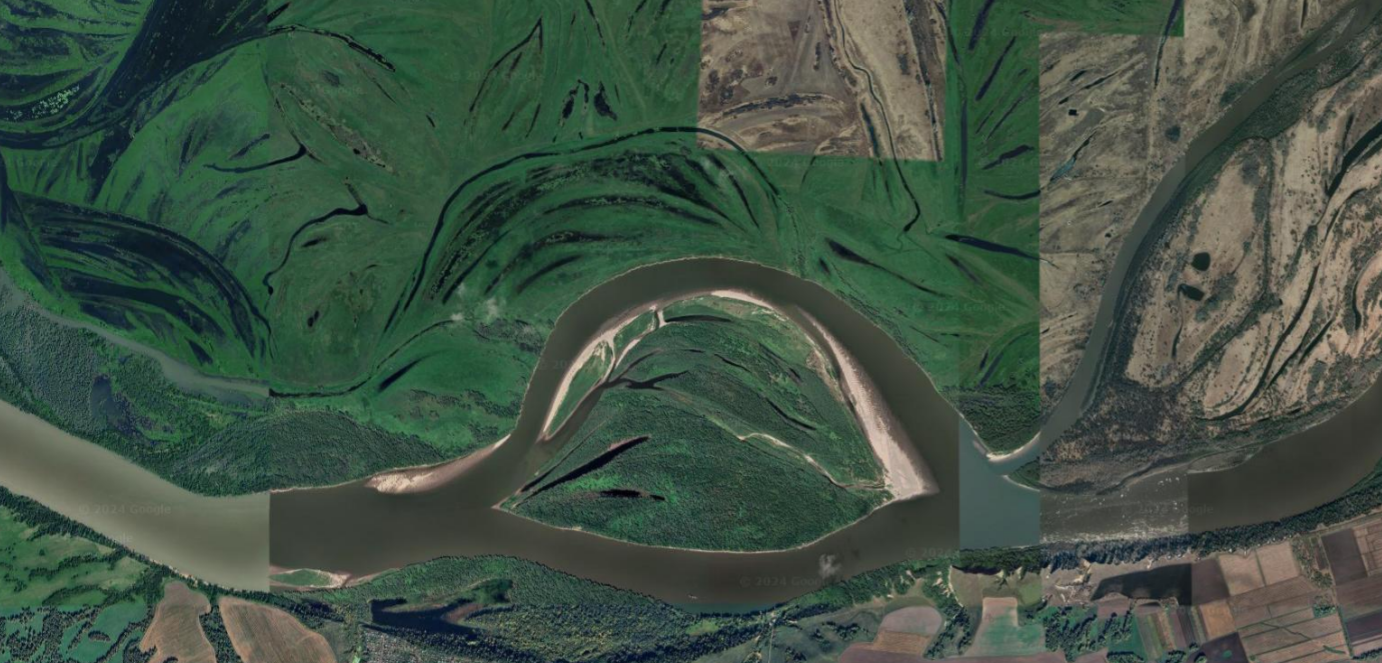

In [9]:
Image.open(custom_dataset[15])

In [27]:
def getCoastlineDistance(img : np.ndarray, verbose=False):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (11,11), sigmaX=2, sigmaY=2)
    
    row, col, _ = img.shape

    rotated_positive = ndimage.rotate(blur, 1)
    rotated_negative = ndimage.rotate(blur, -1)
    #blur = np.uint8(rotated_negative + rotated_positive)

    thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 11, 2)
    thresh = cv.resize(thresh, (col, row), interpolation=cv.INTER_CUBIC)

    kernel = np.ones((5,5), np.uint8)
    opening = cv.morphologyEx(src=thresh, kernel=kernel, iterations=10, op=cv.MORPH_CLOSE)

    opening = 255 - opening

    dist = cv.distanceTransform(opening, cv.DIST_L2, 0)
    dist = cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)

    dilate = cv.erode(opening, kernel, iterations=3).astype(np.uint8)

    if verbose:
        fig, (source, thresh_p, dilate_p, dist_p) = plt.subplots(nrows=4, figsize=(15, 15))
        source.imshow(img)
        source.set_title('Source image')

        thresh_p.imshow(thresh)
        thresh_p.set_title('Adaptive Threshold')

        dilate_p.set_title('Dilate')
        dilate_p.imshow(dilate)

        dist_p.set_title('Distance transforming')
        dist_p.imshow(dist)

    return dist, dilate

def getMarkers(src : np.ndarray, dist : np.ndarray, dilate : np.ndarray, verbose=False):
    cnts, val = np.histogram(dist.ravel())
    grad = np.abs(np.gradient(cnts)[1:]) # skip first delta

    thresh_coef = val[np.argmax(grad) + 1]
    ret, dist_thresh = cv.threshold(dist, thresh_coef, 255, cv.THRESH_BINARY)
    dist_thresh =  ndimage.binary_fill_holes(dist_thresh).astype(np.uint8)
    
    s = cv.subtract(dilate, dist_thresh)

    ret, markers = cv.connectedComponents(dist_thresh)
    markers += 1    

    markers[s == 255] = 0
    markers = cv.watershed(src, markers)

    if verbose:
        fig, (d_hist, d_thresh, markers_p) = plt.subplots(nrows=3, figsize=(10,10))      
        d_hist.hist(dist.ravel())
        d_hist.axvline(1.5 * thresh_coef, color='red', linestyle='dashed', linewidth=2)
        d_hist.set_title(f'Histogram (thresh k = {thresh_coef})')

        d_thresh.imshow(dist_thresh)
        d_thresh.set_title('Distance thresholded')

        markers_p.set_title('Markered')
        markers_p.imshow(markers)

    return markers

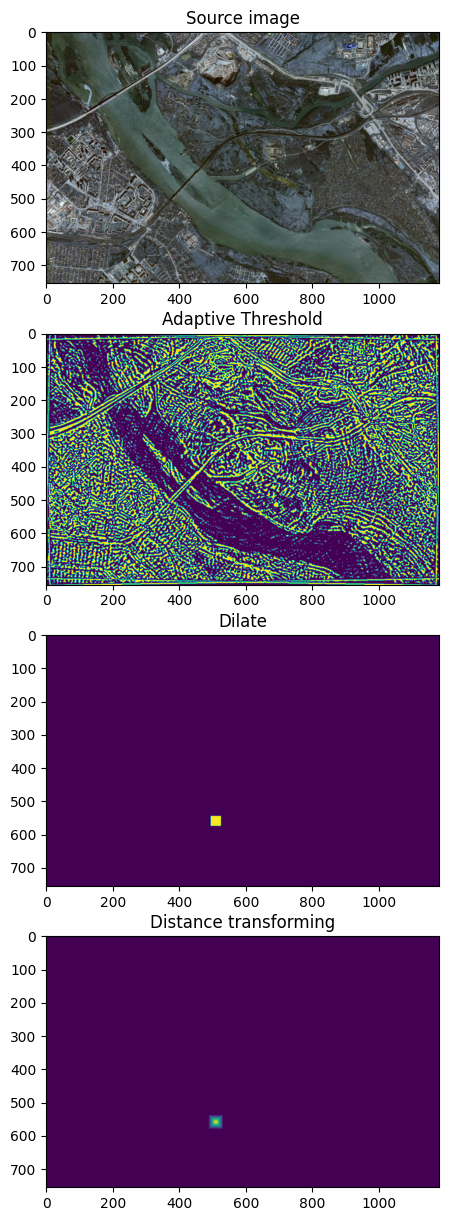

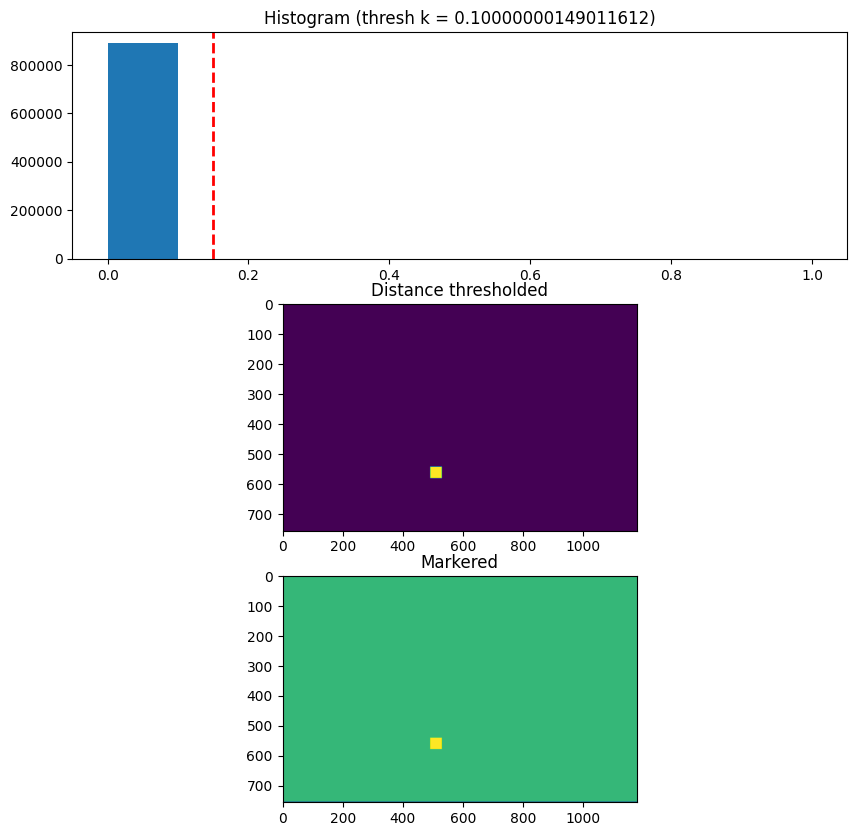

In [47]:
img = cv.imread(custom_dataset[9])
dist, dilate = getCoastlineDistance(img, verbose=True)
markers = getMarkers(img, dist, dilate, verbose=True)

In [28]:


dist, dilate, thresh = getCoastlineDistance(cv.imread('screen1.png'))
rotated_positive = ndimage.rotate(thresh, 1)
rotated_negative = ndimage.rotate(thresh, -1)
dst = np.uint8(rotated_negative + rotated_positive)
Image.fromarray(dst)

ValueError: not enough values to unpack (expected 3, got 2)

In [402]:
model = SAM('sam_b.pt')
result = model('screen3br.png', points=[[800, 1750]])



image 1/1 c:\Users\User\work\excellent-coastlines\screen3br.png: 1024x1024 19936.6ms
Speed: 50.9ms preprocess, 19936.6ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)


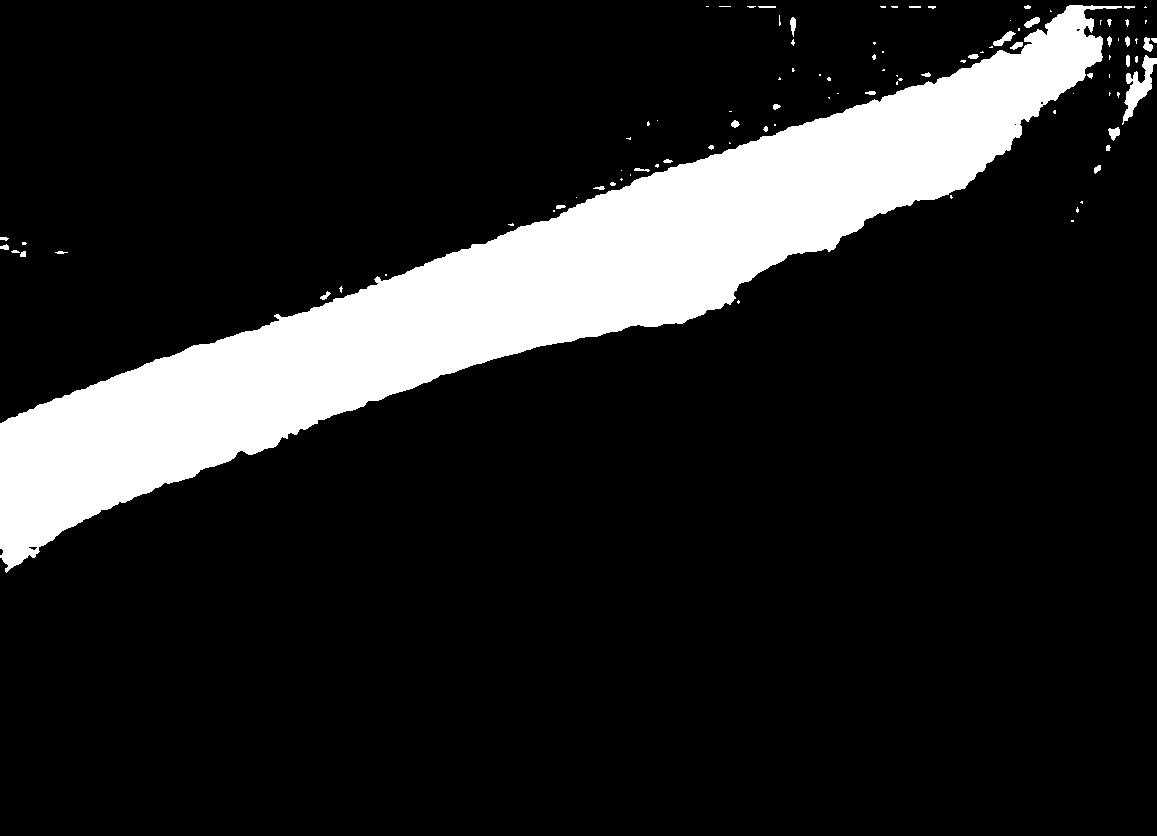

In [398]:
mask = result[0].masks[0].data.numpy()[0].astype(np.uint8)

mask[mask == 1] = 255
Image.fromarray(mask)